In [1]:
import numpy as np
from aisynphys.database import default_db as db
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity, pair_was_probed
from aisynphys.ui.notebook import cell_class_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cell_class_criteria = {
    'l2pyr': {'dendrite_type': 'spiny', 'cortical_layer': '2'},
    'l3pyr': {'dendrite_type': 'spiny', 'cortical_layer': '3'},
    'l4pyr': {'dendrite_type': 'spiny', 'cortical_layer': '4'},
    'l5pyr': {'dendrite_type': 'spiny', 'cortical_layer': '5'},
    'in':  {'dendrite_type': 'aspiny'},
}

class_labels = {
    'l2pyr':  'L2 Spiny',
    'l3pyr':  'L3 Spiny',
    'l4pyr':  'L4 Spiny',
    'l5pyr':  'L5 Spiny',
    'in':  'Aspiny',
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

In [3]:
# Load all cell pairs associated with mouse V1 projects
human_pairs = db.pair_query(project_name=["human coarse matrix"]).all()

print("loaded %d cell pairs" % len(human_pairs))

loaded 10606 cell pairs


In [4]:
# Group all cells by selected classes
cell_groups = classify_cells(cell_classes.values(), pairs=human_pairs)

# Group pairs into (pre_class, post_class) groups
pair_groups = classify_pairs(human_pairs, cell_groups)

# analyze matrix elements
results = measure_connectivity(pair_groups)

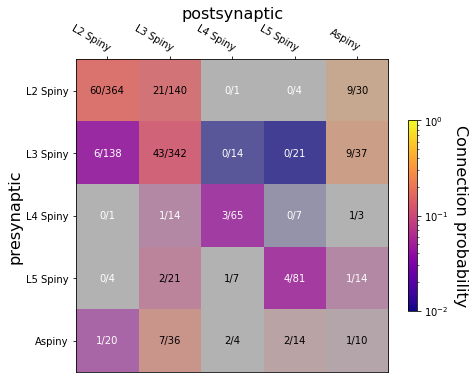

In [5]:
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
from aisynphys.ui.notebook import show_connectivity_matrix


# define a colormap and log normalization used to color the heatmap
norm = matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0, clip=True)
cmap = matplotlib.cm.get_cmap('plasma')

# create a figure/axes to draw on
fig, ax = plt.subplots(figsize=(7, 7))

# finally, draw the colormap using the provided function:
im, cbar, labels = show_connectivity_matrix(
    ax=ax, 
    results=results, 
    pre_cell_classes=cell_classes.values(), 
    post_cell_classes=cell_classes.values(), 
    class_labels=class_labels, 
    cmap=cmap, 
    norm=norm
)
cbar.set_label("Connection probability", size=16)
fig.savefig('human_connectivity_matrix.svg')

/home/luke/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


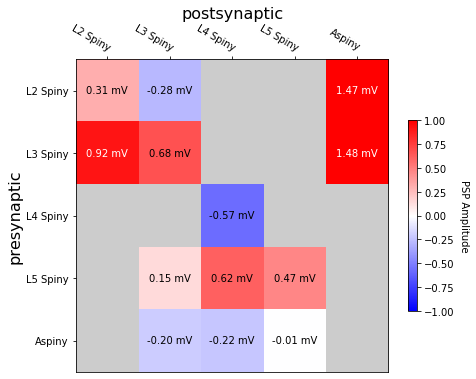

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))
cell_class_matrix(
    pre_classes=cell_classes,
    post_classes=cell_classes,
    metric='psp_amplitude',
    class_labels=class_labels,
    ax=ax,
    db=db,
    pair_query_args={
        'project_name': ["human coarse matrix"],
        'synapse': True,
    },
)
fig.savefig('human_psp_amp_matrix.svg')

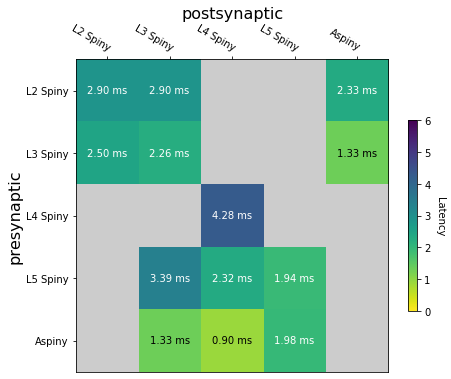

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))
cell_class_matrix(
    pre_classes=cell_classes,
    post_classes=cell_classes,
    metric='latency',
    class_labels=class_labels,
    ax=ax,
    db=db,
    pair_query_args={
        'project_name': ["human coarse matrix"],
        'synapse': True,
    },
)
fig.savefig('human_latency_matrix.svg')

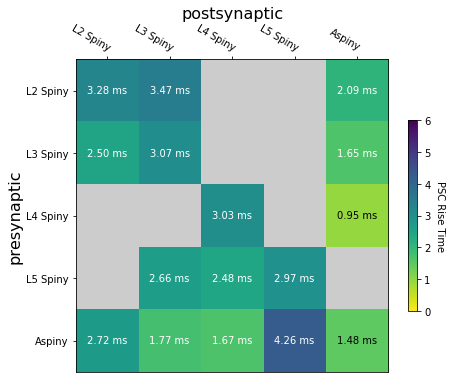

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))
cell_class_matrix(
    pre_classes=cell_classes,
    post_classes=cell_classes,
    metric='psc_rise_time',
    class_labels=class_labels,
    ax=ax,
    db=db,
    pair_query_args={
        'project_name': ["human coarse matrix"],
        'synapse': True,
    },
)
fig.savefig('human_psc_rise_matrix.svg')

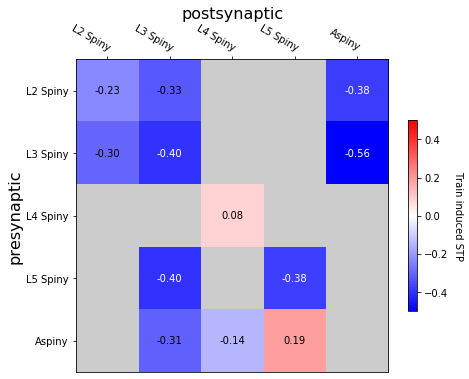

In [9]:
fig, ax = plt.subplots(figsize=(7, 7))
cell_class_matrix(
    pre_classes=cell_classes,
    post_classes=cell_classes,
    metric='stp_induction_50hz',
    class_labels=class_labels,
    ax=ax,
    db=db,
    pair_query_args={
        'project_name': ["human coarse matrix"],
        'synapse': True,
    },
)
fig.savefig('human_stp_induction_matrix.svg')

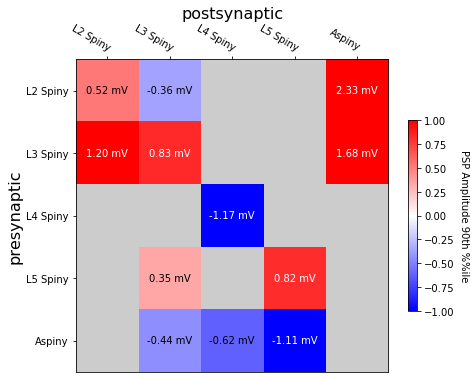

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
cell_class_matrix(
    pre_classes=cell_classes,
    post_classes=cell_classes,
    metric='pulse_amp_90th_percentile',
    class_labels=class_labels,
    ax=ax,
    db=db,
    pair_query_args={
        'project_name': ["human coarse matrix"],
        'synapse': True,
    },
)
fig.savefig('human_90th_percentile_matrix.svg')

In [11]:


# Load all synapses associated with mouse V1 projects
pairs = db.pair_query(
    project_name=["human coarse matrix"],
    synapse=True,
).all()

print("loaded %d synapses" % len(pairs))

loaded 390 synapses


In [12]:
# get a list of all cells in the selected pairs
cells = set([pair.pre_cell for pair in pairs] + [pair.post_cell for pair in pairs])

# Classify each cell. Note that, depending on the class definitions above, a cell could 
# belong to multiple classes. 
cell_class = {}
for cell in cells:
    # which of the classes defined above is this cell a member of?
    cell_in_classes = [cls_name for cls_name, cls in cell_classes.items() if cell in cls]
    cell_class[cell] = ','.join(cell_in_classes)

In [13]:
import pandas

# construct a pandas dataframe containing the pre/postsynaptic cell class names
# and a measure of short-term plasticity
pre_class = [cell_class[pair.pre_cell] for pair in pairs]
post_class = [cell_class[pair.post_cell] for pair in pairs]
stp = [None if pair.dynamics is None else pair.dynamics.stp_induction_50hz for pair in pairs]

df = pandas.DataFrame(
    zip(pairs, pre_class, post_class, stp), 
    columns=['pair', 'pre_class', 'post_class', 'stp']) 

# select out only cells that are a member of exactly 1 class
mask = df.pre_class.isin(cell_classes) & df.post_class.isin(cell_classes)
df = df[mask]

# select only pairs with a measured stp
df = df.dropna()

df.head()

,pair,pre_class,post_class,stp
6,<Pair 1534394748.497 4 7>,l5pyr,l3pyr,-0.400713
26,<Pair 1548200410.746 3 5>,l3pyr,l3pyr,-0.594401
37,<Pair 1507690323.707 5 6>,l3pyr,in,-0.811485
38,<Pair 1520997064.505 5 4>,l3pyr,l3pyr,-0.615449
49,<Pair 1507690323.707 5 3>,l3pyr,l3pyr,-0.177132


In [14]:
stp = df.pivot_table('stp', 'pre_class', 'post_class', aggfunc=np.nanmean)

# sort rows/cols into the expected order
order = list(cell_classes)
stp = stp[order].loc[order]

stp

post_class,l2pyr,l3pyr,l4pyr,l5pyr,in
pre_class,,,,,
l2pyr,-0.230709,-0.326183,NaN,NaN,-0.379990
l3pyr,-0.300080,-0.401134,NaN,NaN,-0.558059
l4pyr,NaN,NaN,0.084660,NaN,NaN
l5pyr,NaN,-0.400713,NaN,-0.376016,NaN
in,NaN,-0.310723,-0.142874,0.187793,NaN


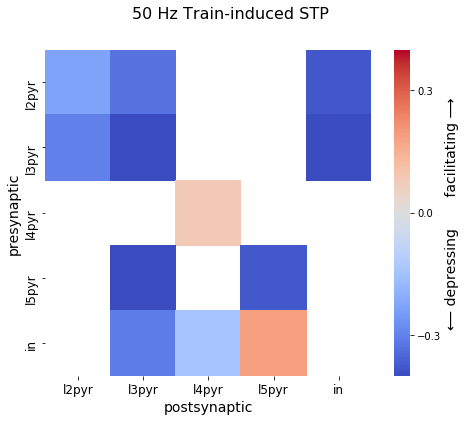

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig,ax = plt.subplots(figsize=(8, 6))

hm = sns.heatmap(stp, cmap='coolwarm', vmin=-0.4, vmax=0.4, square=True, ax=ax,
                cbar_kws={"ticks":[-0.3, 0, 0.3], 'label': '⟵ depressing       facilitating ⟶'})

fig.suptitle("50 Hz Train-induced STP", fontsize=16)
hm.set_xlabel("postsynaptic", fontsize=14)
hm.set_ylabel("presynaptic", fontsize=14);
hm.figure.axes[-1].yaxis.label.set_size(14)
hm.tick_params(labelsize=12)

In [16]:
# query once for each postsynaptic type, building up a Pandas dataframe

pairs = None
# pair_classes = [
#     ('l23pyr', 'l23pyr'),
#     ('l23pyr', 'vip'),
    
#     ('l4pyr', 'sst'),
    
#     ('l5et', 'l5et'),
#     ('l5et', 'pv'),

#     ('l6pyr', 'pv'),
#     ('l6pyr', 'sst'),
    
#     ('pv', 'l5et'),
#     ('pv', 'l5it'),
    
#     ('sst', 'l6pyr'),
#     ('sst', 'vip'),
    
#     ('vip', 'l23pyr'),
#     ('vip', 'vip'),
# ]

pair_classes = [
    ('l2pyr', 'l2pyr'),
    ('l3pyr', 'l3pyr'),
    #('l4pyr', 'l4pyr'),
    ('l3pyr', 'in'),
    ('l2pyr', 'in'),
]    
for pre_name, post_name in pair_classes:
    pre_class = cell_classes[pre_name]
    post_class = cell_classes[post_name]
    pair_query = db.pair_query(
        project_name=["human coarse matrix"],
        pre_class=pre_class,
        post_class=post_class,
        synapse=True,
    )
    pair_query = pair_query.add_columns(
        db.Synapse.psp_amplitude,
        db.Synapse.latency,
        db.Synapse.psc_rise_time,
        db.Dynamics.pulse_amp_90th_percentile,
        db.Dynamics.stp_initial_50hz,
        db.Dynamics.stp_induction_50hz,
        db.Dynamics.stp_recovery_250ms,
    )
    
    df = pair_query.dataframe()
    df['pre_class'] = pre_name
    df['post_class'] = post_name
    df['pair_class'] = pre_name + "→" + post_name
    if pairs is None:
        pairs = df
    else:
        pairs = pairs.append(df)
    print("%s->%s: %d synapses" % (pre_name, post_name, len(df)))

l2pyr->l2pyr: 60 synapses
l3pyr->l3pyr: 43 synapses
l3pyr->in: 9 synapses
l2pyr->in: 9 synapses


In [17]:
np.nanmean(pairs[pairs['pair_class']=="in→l5pyr"]['stp_induction_50hz'])

/home/luke/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


nan

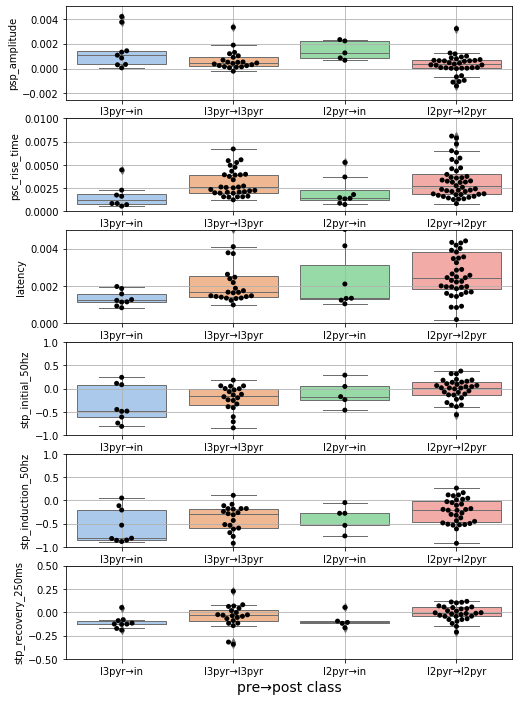

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

limits = {
    'psp_amplitude': (-2.5e-3, 5.0e-3),
    'psc_rise_time': (0, 10e-3),
    'latency': (0, 5e-3),
    #'pulse_amp_90th_percentile': (-5.0e-3, 5.0e-3),
    'stp_initial_50hz': (-1.0, 1.0),
    'stp_induction_50hz': (-1.0, 1.0),
    'stp_recovery_250ms': (-0.5, 0.5),
}
units = ['ms', 'ms', 'ms', 'mV']
ticks = {
    'ms': 0.5e-3 * 2**np.arange(4),
    'mV': 20e-6 * 4**np.arange(4),
}

stp_mean = pairs.groupby('pair_class').mean()['stp_initial_50hz']
order = stp_mean.argsort()
index_order = stp_mean.index[order]

fig,ax = plt.subplots(len(limits), 1, figsize=(8, 2.0 * len(limits)))


for i, (field, lim) in enumerate(limits.items()):
    # box and swarm plots
    #ax[i].set_yscale('log')
    ax[i].set_ylim(*lim)
    sns.boxplot(x="pair_class", y=field, data=pairs, order=index_order, ax=ax[i], palette='pastel', width=0.8, linewidth=1)
    sns.swarmplot(x="pair_class", y=field, data=pairs, order=index_order, ax=ax[i], size=5, color=(0, 0, 0, 0.5))
    
    # clean up labels / ticks
    if i == len(limits)-1:
        ax[i].set_xlabel('pre→post class', size=14)
    else:
        ax[i].set_xlabel('')
    #ax[i].set_ylabel(field.replace('_', ' ') + ' (%s)'%units[i], size=12)
    #ax[i].set_yticks(ticks[units[i]])
    #ax[i].set_yticklabels(['%0.2f' % (x*1000) for x in ticks[units[i]]])
    ax[i].set_yticklabels([], minor=True)
    ax[i].grid()
    
fig.savefig('human_synaptic_feature_beeswarm.svg')